# Modelling a PMT sensor

In this project, we are going to produce a model to simulate the measurements of a [PMT sensor](https://en.wikipedia.org/wiki/Photomultiplier_tube) like the ones available in [TPC detectors](https://en.wikipedia.org/wiki/Time_projection_chamber).

## Introduction

PMT sensors produce a 1D signal whoes value changes over time depending on the light received and the noise affecting the sensor. Our goal is to produce time series as similar as possible to the ones produced by the actual sensor. Next, we are going to present the tools we are going to use and the available data.

### Importing required Python libraries

For the modelling, we are going to need some commonly used libraries:

In [1]:
import pathlib
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

### Loading available data

Since we don't have tons of data for this project, we can load all the four independent measurements and store them in variables to ease the access in the future.

In [2]:
samples_path = pathlib.Path('samples') # Folder containing the actual sensor measurements

T, X = [], []                          
for file in samples_path.iterdir():
    t, x = np.loadtxt(file, delimiter='\t', dtype=np.float32, skiprows=5).T
    T.append(t)
    X.append(x)

### Inspecting the raw data from the sensor

To get an overall idea on how the target data looks like, let's plot all the four measurements we have available.

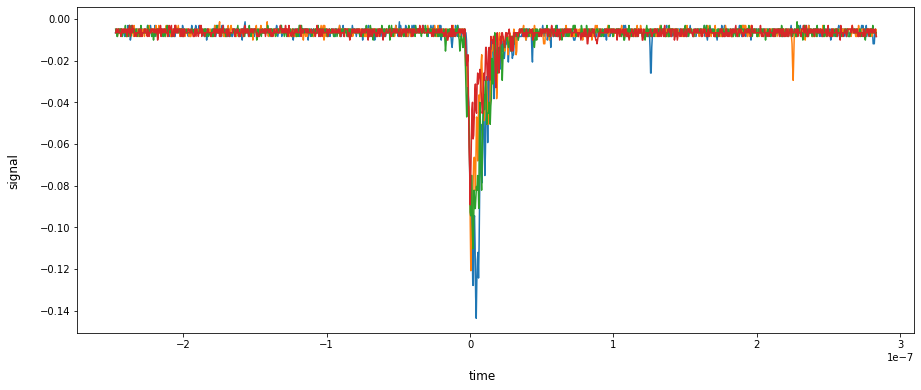

In [3]:
fig = plt.figure(figsize=(15,6))
for t, x in zip(T, X):
    plt.plot(t, x)

fig.supxlabel('time')
fig.supylabel('signal', x=.06)
plt.show()

Here, we can notice how the measurement is clearly composed by the signal starting around $t=0$ and noise present all over the time.

## Modelling the noise in the sensor

To study the charateristics of the noise present in those signals, we should start by taking only the slices with no other contribution (i.e., the samples taken before the peak near $t=0$). Let us plot that region and observe the noise:

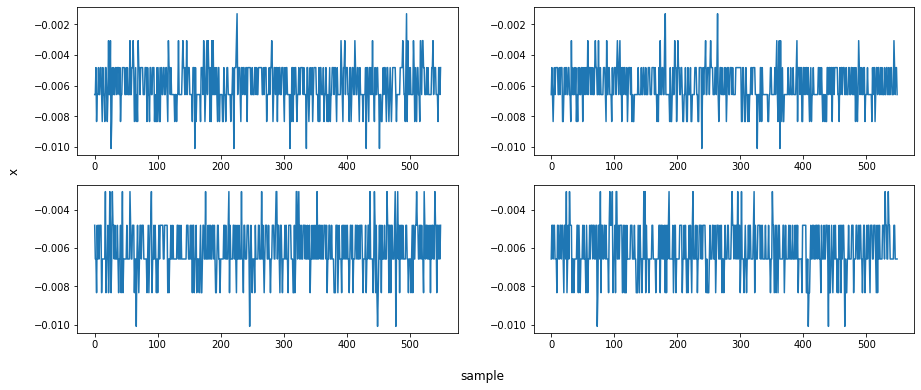

In [4]:
final_sample = 550
x = np.transpose([x[:final_sample] for x in X])

fig = plt.figure(figsize=(15,6))
for i, x_ in enumerate(x.T):
    plt.subplot(2, 2, i + 1)
    plt.plot(x_)
fig.supxlabel('sample')
fig.supylabel('x', x=.06)
plt.show()

There are some hints we can get from this plot:

* Noise is distributed around a constant value that doesn't change over time on any independent sample
* Noise values seem to take only a few discrete values. This is probably due to the sensor resolution and not because of the noise nature itself

Since the mean value is constant, we should start by searching any possible time correlation among the samples. Let us compute the autocorrelation as a function of the lag time for each realization:

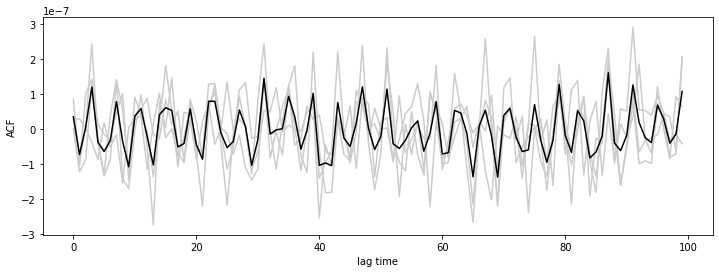

In [5]:
max_lag = 100 
x_mean = x.mean(0)
x_zm = x - x_mean
ACF = np.array(
    [(x_zm[:-lag] * x_zm[lag:]).mean(0) 
    for lag in range(1, max_lag + 1)]
)
x_mean = x.mean()

plt.figure(figsize=(12,4))
plt.plot(ACF, '.8')
plt.plot(ACF.mean(1), 'k')
plt.xlabel('lag time')
plt.ylabel('ACF')
plt.show()

We can see the noise autocorrelation is extremely low (above 0.000001). Then, we can model the noise as a stationary noise using a simple random variable. Now, let us inspect an histogram with all samples from every signal (from the noise-only region) to understand how they are distributed:

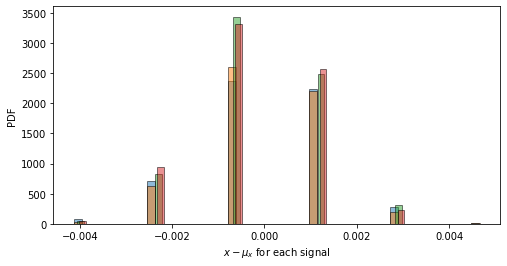

In [6]:
plt.figure(figsize=(8,4))
[plt.hist(x_, bins=50, density=True, alpha=.5, ec='k') for x_ in x_zm.T]
plt.xlabel('$x - \mu_x$ for each signal')
plt.ylabel('PDF')
plt.show()

From this plot we can see we may be getting a simmetric distribution, but it is still unclear due to the discretization of the samples. Let's start by creating a function that enable us to test experimental data against the common distributions available in scipy.

In [7]:
def fit_dist(x, dist='norm', xmin=None, xmax=None, num=300):
    
    xmin = x.min() if xmin is None else xmin
    xmax = x.max() if xmax is None else xmax
        
    dist = getattr(scipy.stats, dist)
    *args, loc, scale = dist.fit(x)
    
    x_pdf = np.linspace(xmin, xmax, num)
    y_pdf = dist.pdf(x_pdf, *args, loc=loc, scale=scale)
    return x_pdf, y_pdf, (*args, loc, scale)

Now, let us try to fit all our data (all noise samples from every signal) using a gaussian distribution:

In [8]:
x_zm_concat = np.hstack(x_zm)
x_pdf, y_pdf, params = fit_dist(x_zm_concat)
mu, sigma = params[0], params[1]
print(f'mu={mu}, sigma ={sigma}')


mu=-6.180594924742877e-11, sigma =0.0013602945255115628


Then, let us compare the theoretical distribution against our data in a plot that:

* Combines all the samples together
* Subtracts the mean value to center de distribution
* Uses log scale, in which gaussian distributions show as a quadratic functions.

Text(0, 0.5, 'PDF')

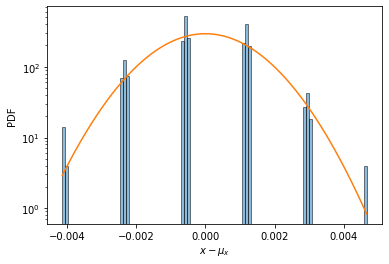

In [9]:
plt.hist(x_zm_concat, bins=100, density=False, alpha=.5, ec='k')
plt.plot(x_pdf, y_pdf)
plt.yscale('log')
plt.xlabel('$x - \mu_x$')
plt.ylabel('PDF')

We can see our data is well fitted using a Gaussian distribution. Just to add an extra check, let us plot the Gaussian fit against the distribution of each individual signal. 

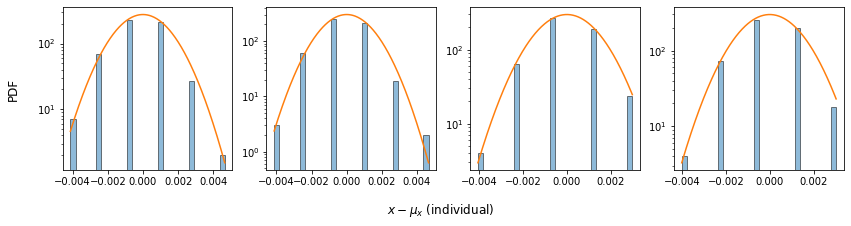

In [10]:
fig = plt.figure(figsize=(14,3))
for i, x_ in enumerate(x_zm.T):
    x_pdf, y_pdf, params = fit_dist(x_)
    plt.subplot(1, 4, i + 1)
    plt.hist(x_, bins=30, density=False, alpha=.5, ec='k')
    plt.plot(x_pdf, y_pdf)
    plt.yscale('log')
fig.supylabel('PDF', x=.07)
fig.supxlabel('$x - \mu_x$ (individual)', y=-.1)
plt.show()

Since even independent realizations look well fitted with the Gaussian distribution we can conclude that the noise in the sensor follows a Gaussian distribution with the computed values of $\mu$ and $\sigma$. Note that we centered the distribution before estimating sigma, so the mean value we subtracted is the actual mean of the distribution.

In [11]:
noise = lambda x : np.random.normal(x_mean, sigma, x)

Now, we can generate noise samples that follows the same statistical distribution of the data.

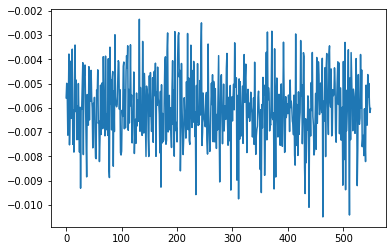

In [12]:
x = noise(final_sample)
plt.plot(x)

We can notice that we are getting high resolution noise in the y-axis which is different from the actual data. Next, let us model the sensor resolution and apply the equivalent discretization to our noise.

## Modelling the sensor resolution

The PMT sensor provides discrete samples of the variable with a time spacing defined as time resolution. In addition, the value of the signal can not be retreived with infinite resolution due to the digital nature of the acquisition systems, the minimal difference among values detected by the sensor is called signal resolution.

### Measuring the time resolution

To measure the time resolution, we just need to inspect the time step distribution among all the samples to verify it is constant and estimate its value.

In [13]:
DT = [np.ediff1d(t) for t in T]
all_dt = np.hstack(DT)

time_resolution = all_dt.mean()
std_dt = all_dt.std()
print(f'The time resolution is {time_resolution}, with a standard deviation of {std_dt}')

The time resolution is 4.000000330961484e-10, with a standard deviation of 1.1758462245873257e-14


We can see that the sampling time is quite constant since the standard deviation is 4th orders of magnitude under the mean value. Therefore, we can state that the sampling time is constant and with a value of $4 \times 10^{-10}$ s.

### Measuring the signal resolution

To measure the signal resolution, we need to inspect the distribution of the samples and try to identify if all the samples are multiples of a given value. If that is the case, that value will be considered the signal resolution. We are going to test that in the 4 independent samples of the signal.

Found 117 different deltas


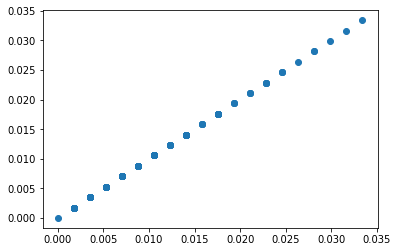

In [14]:
# Get all the deltas
deltas = []
for signal in X:
    deltas.append(np.abs(np.ediff1d(signal)))
deltas = np.hstack(deltas)

# Filter duplicated deltas
deltas_un = np.unique(deltas)       
print(f'Found {deltas_un.shape[0]} different deltas')
plt.scatter(deltas_un, deltas_un)  
plt.show()

We found **117** different incremental values (deltas) in our data. However, from the plot, we can notice that we can only distinguish by eye **20** different groups. What is happening is that some of the deltas are caused by the floating point error and others are caused by the discretization of the sensor. There are many ways to disentangle both groups, but in our case it is quite easy since we can inspect the uniform spacing in the delta.

In [15]:
min_delta = np.min(deltas_un)
max_delta = np.max(deltas_un)
equispaced_clusters = 20

signal_resolution = (max_delta - min_delta)/ (equispaced_clusters - 1)

Let us produce a plot with our estimated signal resolution and compare with the actual deltas measured.

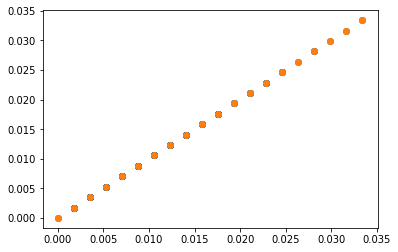

In [16]:
theoretical_deltas = [i*signal_resolution for i in range(20)]

plt.scatter(deltas_un, deltas_un)  
plt.scatter(theoretical_deltas, theoretical_deltas)  
plt.show()

We can notice the perfect overlap indicating that we have captured the discretization performed on the sensor samples.

## Modeling the effect of interacting particles in the pmt readout

*[Comming soon]*

## Generation of fake sensor measurements (Integration of all the models)

Now, we are able to put all the pieces together and build a model that simulates the signal obtained in a pmt sensor. Let us start by defining a function that integrates all the models.

In [17]:
def read_pmt(num_samples):
    
    # Simulate sampling time using uniform sampling
    time_array = np.arange(0, time_resolution * num_samples, time_resolution)
    
    # simulate signal array with the sensor noise
    signal_array = noise(num_samples)
    
    # simulate the discretization of the sensor
    signal_array = signal_array / signal_resolution
    signal_array = np.rint(signal_array) * signal_resolution
    
    return time_array, signal_array

Now, let us test the simulator by generating 4 signals of a noise-only readout so we can compare them with the ones we saw at the begining of this notebook.

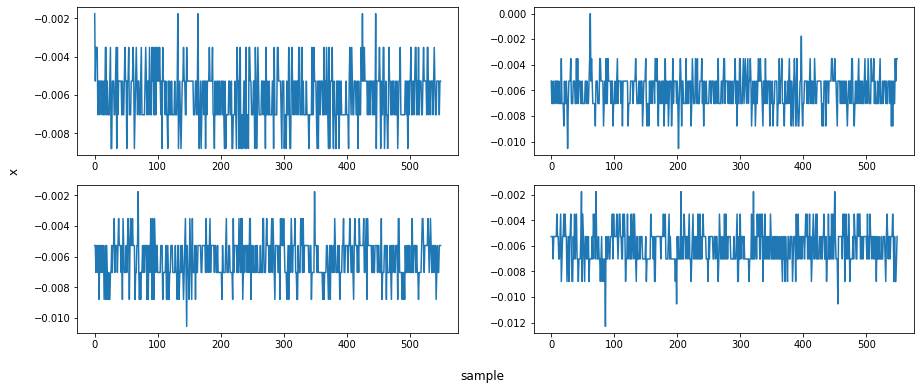

In [18]:
total_samples = 550
signals = []

for i in range(4):
    t, s = read_pmt(total_samples)
    signals.append(s)

fig = plt.figure(figsize=(15,6))
for i, x_ in enumerate(signals):
    plt.subplot(2, 2, i + 1)
    plt.plot(x_)
fig.supxlabel('sample')
fig.supylabel('x', x=.06)
plt.show()

## Acknowledgment

This work was performed using data from [CYGNO project](https://github.com/CYGNUS-RD). I want to thank [Alfredo Reyes](https://github.com/orgs/yupidevs/people/alpelito7) for the insightful dicussions.